## Gait Video Study 
### Identifying frames with HSRs in each video for each cohort and trial to establish break points and also evaluate the corresponding HSR labelling via the ground truth available. Further, downsample with smoothing to define fixed shape of the input tensor for models. 
#### Remember to preserve the original count of frames in a single stride (before down sampling via smoothing) for each stride to add as an additional artificial feature later to add information about speed of the subject to the model

In [422]:
import numpy as np
import cv2
import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.display import display
import time
import shutil
import scipy
from scipy import signal, stats
from scipy.signal import lfilter, firwin, filtfilt, find_peaks, argrelextrema
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML

In [423]:
path = 'C:\\Users\\purpl\\Box\\Gait Video Project\\GaitVideoData\\video\\frame_data'
frame_path_merged = 'C:\\Users\\purpl\\Box\\Gait Video Project\\GaitVideoData\\video\\multi_view_merged_data\\'
#Folder to store the downsampled hip height normalized multi view merged files for models 
downsample_path = 'C:\\Users\\purpl\\Box\\Gait Video Project\\GaitVideoData\\video\\downsampled_data\\'

#Configuration for which to run the code for 
cohorts = ['\\HOA', '\\MS', '\\PD', '\\ExtraHOA']
trials = ['\\beam_walking', '\\walking']
cameras = ['\\feet\\', '\\lower_body\\']

order = ['right hip', 'right knee', 'right ankle', 'left hip', 'left knee', 'left ankle', 'left toe 1', 'left toe 2', \
         'left heel', 'right toe 1', 'right toe 2', 'right heel']

In [424]:
#Saving the HSRframes.txt file to the hip_height_normalized\\ containing the final .csvs for analysis
# for cohort in cohorts:
#     for trial in trials:
#         merged_path = frame_path_merged+cohort+trial 
#         if (os.path.exists(merged_path)):
#             videos = os.listdir(merged_path)
# #             print (len(videos))
#         for video in videos:
#             print (glob.glob(path+cohort+trial+'\\feet\\'+'Inked'+video+'_0_Trim'))
#             try:
#                 if (not os.path.exists(merged_path+'\\'+video+'\\HSRframes.txt')):
#                     HSR_frames_file = path+cohort+trial+'\\feet\\'+'Inked'+video+'_0_Trim'+'\\HSRframes.txt'
#                     shutil.copy(HSR_frames_file, merged_path+'\\'+video+'\\hip_height_normalized\\') 
#                     print ('HSR for', video, 'copied')
#                 else:
#                     print ('HSR for', video, 'exists')
#             except Exception as e:
#                 print (e)

### Utility functions 

In [425]:
# Function to create a dataframe to hold all 12*3 features (right hip-x, right hip-y, ...) 
#as columns and all frames as rows for each video 
def compute_video_features(sorted_frames, labels):
    '''
    Input: sorted frames for the video and labels for the dataframe
    Returns: dataframe to hold all 12*3 features as columns and all frames as rows
    '''
    video_features = pd.DataFrame(columns = labels)
    for frame in sorted_frames:
        #Append the frame number also in the temp dataframe, since it the 
        #true HSR is given in frame number
        frame_no = int(frame.split('\\')[-1][:-4])
        frame_csv = pd.read_csv(frame, index_col = 0)
        #Appending the 36 features and frame number of each frame as 
        #a row for each video's dataframe 
        video_features.loc[len(video_features)] = np.append(frame_no, frame_csv[['x', 'y', 'z']].values.flatten())
    video_features = video_features.astype({'frame_number': 'int'})
    #Setting the frame number as the index 
    video_features.set_index('frame_number', inplace = True)
    #                 display(video_features)
    return video_features

In [449]:
#Function to plot the given feature across frames of a video and the corresponding ground truth and detected HSRs
def plot_true_HSR(signal, index, HSRindices, video, detectedHSR):
    fig= plt.figure(figsize = (8.5, 3))
    ax1 = fig.add_subplot(111)
    #Right heel height series 
    ax1.plot(index, signal, color = 'b', ls='solid', label = 'right heel height')
    #True HSRs
    ax1.plot(index[HSRindices], signal[HSRindices], 'r*', ms = 8, alpha = 1, label = 'true HSR')
    #Detected HSRs
    ax1.plot(index[detectedHSR], signal[detectedHSR], 'gd', ms = 6, alpha = 0.5, label = 'detected HSR')
    plt.xticks(index[0::40], fontsize = 8)
    plt.legend()
    plt.title('Detected and true HSRs using filtered right heel height')
    plt.savefig('HSR_detection_figs_values\\'+ video+ '_filtered_right_heel_z.png', dpi = 300)
    plt.show()
#     plt.close()

In [427]:
#Function to compute the detected HSRs from the right heel height series 
#Briefly, it fills missing values, filters, detects local minimas at a pre-assumed distance of 30 frames (1 second)
def compute_HSR(series_complete, trueHSR_indices_complete, video):
    '''
    Input: right heel height series, true HSR indices, video name
    Returns: Detected HSRs
    '''
    #First we use index aware linear interpolation to fill up the right heel height for the missing frames
    series_complete.interpolate(method='values', inplace = True)
    
    #Filtering the series using low pass FIR filter with cutoff of 0.3 i.e.   
    #0.3 = cutoff_in_Hz/Nyquist rate of the signal  where Nyquist rate of the signal = sample rate/2 = 30 frames/2 
    #hence, cutoff_in_Hz = 0.3*15 = 4.5 frames 
    #Further, length of the filter (number of coefficients, i.e. the filter order + 1) is 5
    a = signal.firwin(5, cutoff = 0.3, window = "hamming") 
    #Low pass filter with window length of 5 and cutoff frequency of 0.3/4.5 frames
    fir_series = signal.lfilter(a, [1.0], series_complete.values)
    
    #Identifying local minimum in right heel's height to define HSRs
    #Assuming that HSRs are atleast 30 frames apart (i.e. atleast a second apart)
    detectedHSR, _ = find_peaks(-fir_series, distance = 30) 
    
    #Plotting the right heel height (with the missing frames filled) and ground truth HSR 
    plot_true_HSR(fir_series, series_complete.index, trueHSR_indices_complete, video, detectedHSR)
    return detectedHSR

In [428]:
#Function to compute the error between the true and detected HSRs for a video
def compute_error_HSR(detectedHSR, trueHSR_indices):
    '''
    Input: A list of true and detected HSR indices for a video
    Returns: error list, absolute error list, mean, standard deviation error over a video (in frames) and 
    mean, standard deviation of absolute error over a video (in frames)
    To convert to seconds, divide by 30, since we have 30 frames per second.
    '''
    abs_error_indices = [np.argmin(abs(i-trueHSR_indices)) for i in detectedHSR]
    error = [i-trueHSR_indices[j] for i, j in zip(detectedHSR, abs_error_indices)]
    abs_error = list(map(abs, error))
    error_stats = [np.mean(error), np.std(error), np.mean(abs_error), np.std(abs_error)]
    return error, abs_error, error_stats

In [429]:
def rename(dataframe):
    dataframe['cohort'][dataframe.cohort=='\\ExtraHOA'] = 'HOA'
    dataframe['cohort'][dataframe.cohort=='\\HOA'] = 'HOA'
    dataframe['cohort'][dataframe.cohort=='\\MS'] = 'MS'
    dataframe['cohort'][dataframe.cohort=='\\PD'] = 'PD'
    dataframe['trial'][dataframe.trial=='\\beam_walking'] = 'BW'
    dataframe['trial'][dataframe.trial=='\\walking'] = 'W'

In [430]:
#Function to define the label for each video
def define_label(cohort):
    '''
    Input: cohort
    Returns: label (0/1/2)
    '''
    if ((cohort == '\\HOA') or (cohort == '\\ExtraHOA')):
        label = 0
    elif cohort == '\\MS':
        label = 1
    else:
        label = 2
    return label

### main() function 

In [431]:
labels = ['frame_number'] + [o + '-'+ y for o in order for y in ['x', 'y', 'z']]
#Saves cohort, trial, video name, mean, std, abs mean, abs std for the error series, count of true HSRs
#, count of detected HSRs, the actual error series for each video and the absolute error series for each video
cols = ['cohort', 'trial', 'video', 'heel_mean_error', 'heel_std_error', 'heel_abs_mean_error',\
        'heel_abs_std_error', 'count_trueHSR', 'count_detectedHSR', 'error_list', 'abs_error_list']
dataframe_error_stats = pd.DataFrame(columns = cols)

GVS_212_T_T1


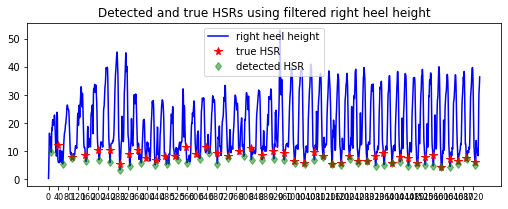

GVS_212_T_T2


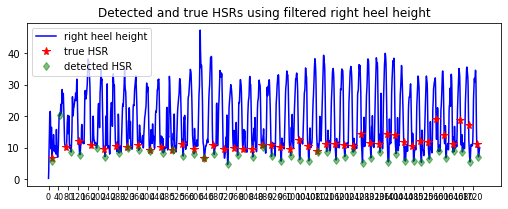

GVS_213_T_T1


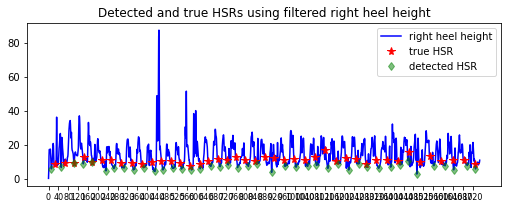

GVS_213_T_T2


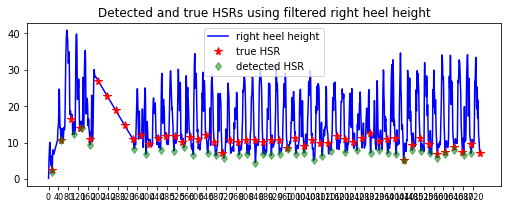

GVS_214_T_T1


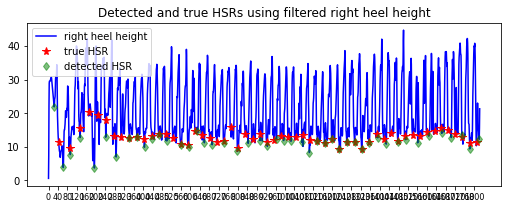

GVS_214_T_T2


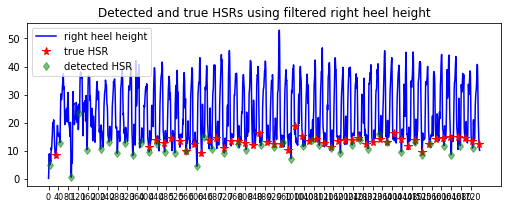

GVS_215_T_T1


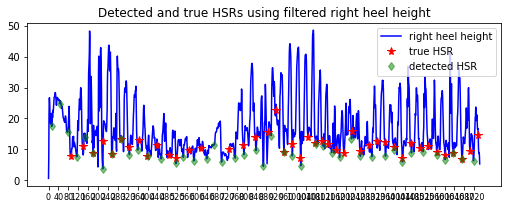

GVS_215_T_T2


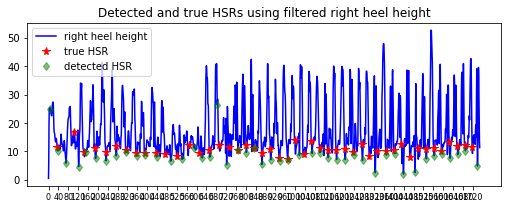

GVS_216_T_T1


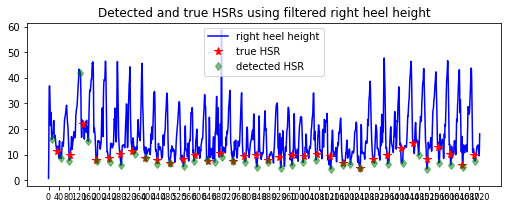

GVS_216_T_T2


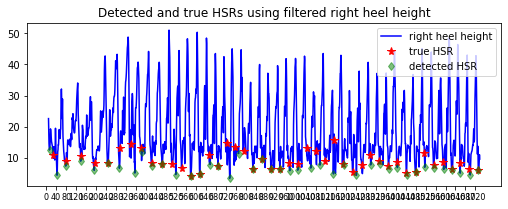

GVS_217_T_T1


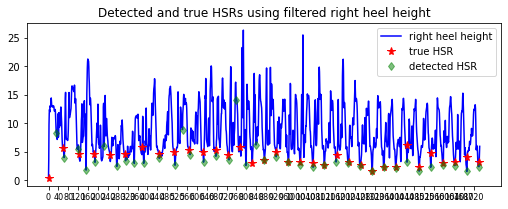

GVS_217_T_T2


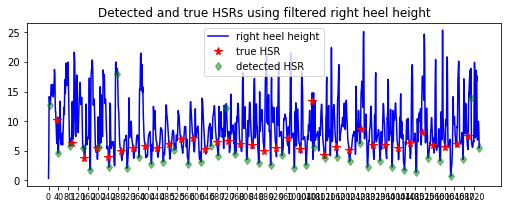

GVS_218_T_T1


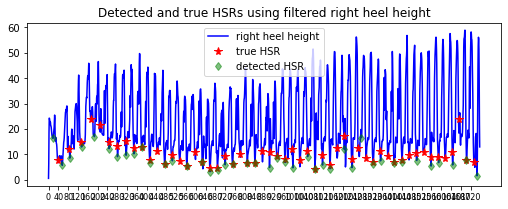

GVS_218_T_T2


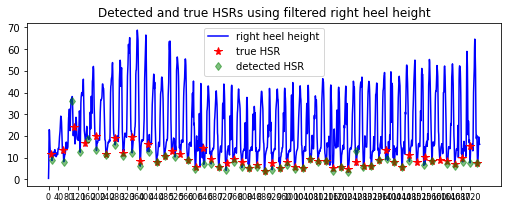

GVS_219_T_T1


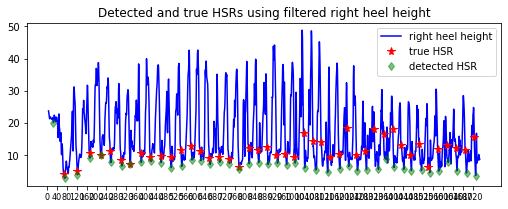

GVS_219_T_T2


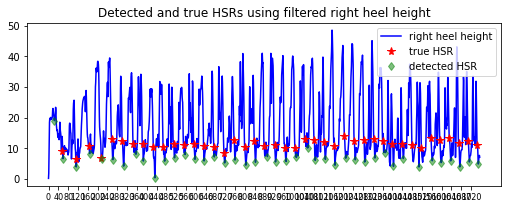

GVS_212_W_T1


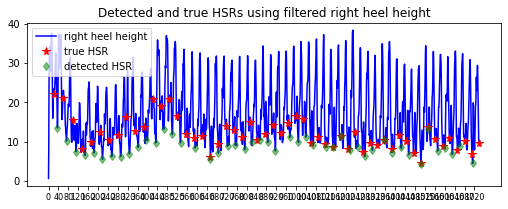

GVS_212_W_T2


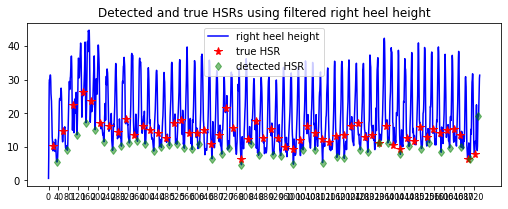

GVS_213_W_T1


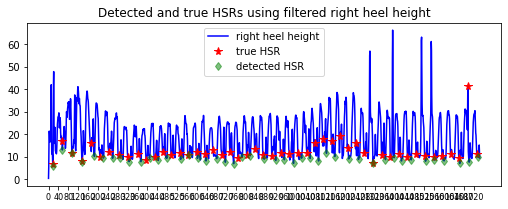

GVS_213_W_T2


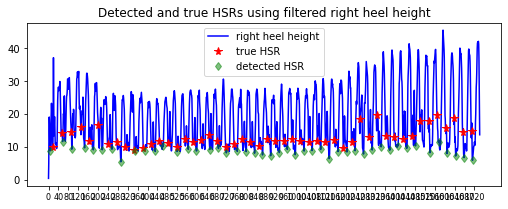

GVS_214_W_T1


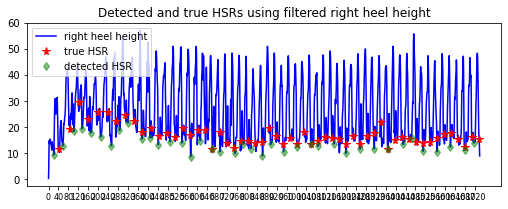

GVS_214_W_T2


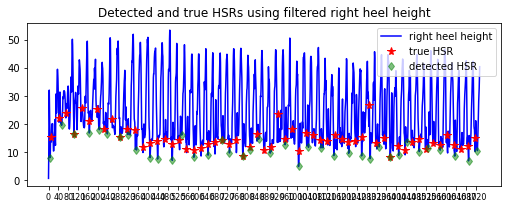

GVS_215_W_T1


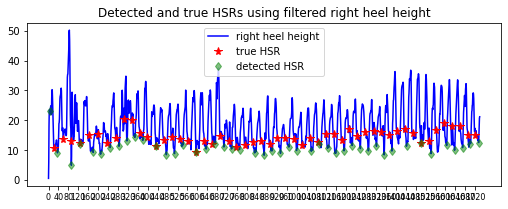

GVS_215_W_T2


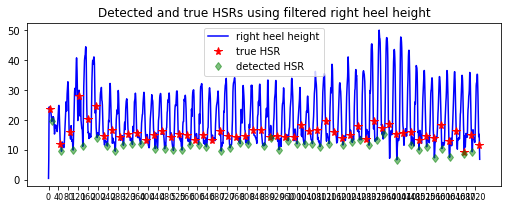

GVS_216_W_T1


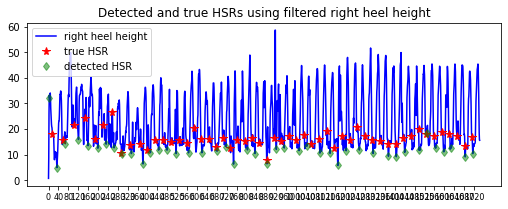

GVS_216_W_T2


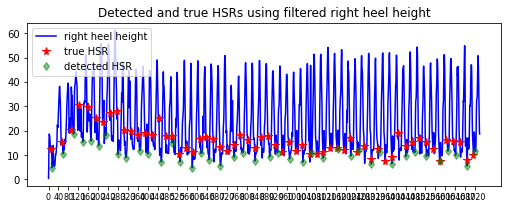

GVS_217_W_T1


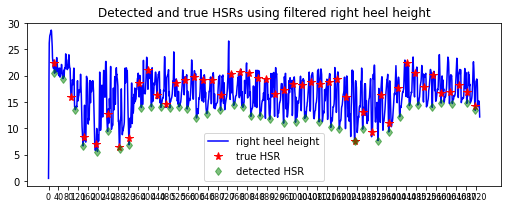

GVS_217_W_T2


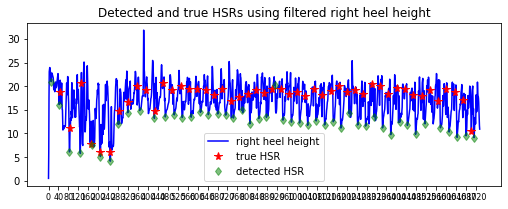

GVS_218_W_T1


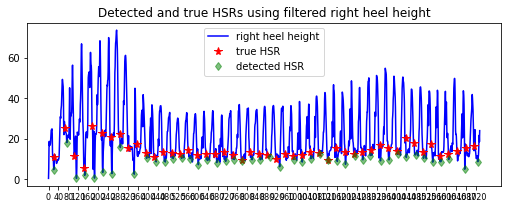

GVS_218_W_T2


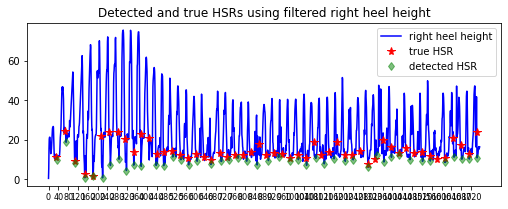

GVS_219_W_T1


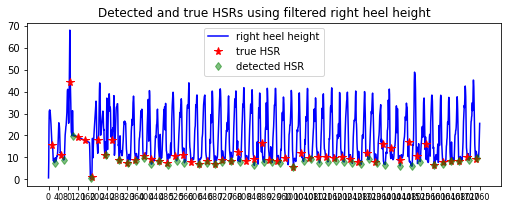

GVS_219_W_T2


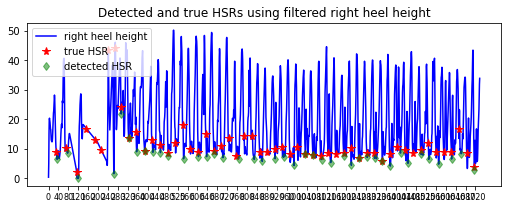

GVS_310_T_T1


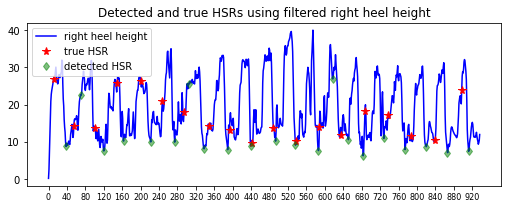

GVS_310_T_T2


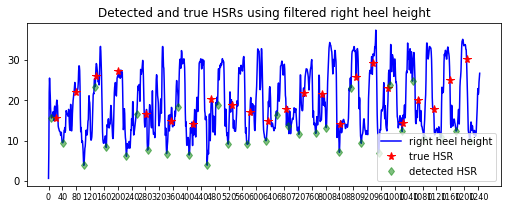

GVS_311_T_T1


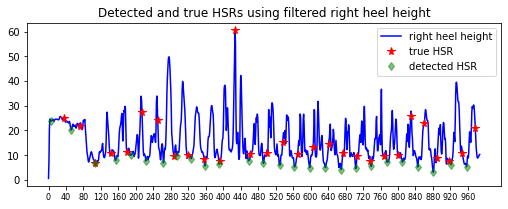

GVS_311_T_T2


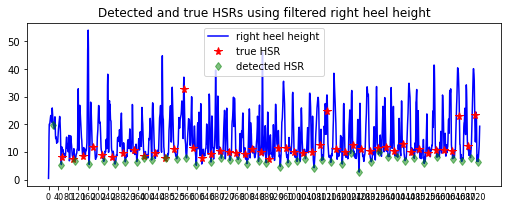

GVS_312_T_T2


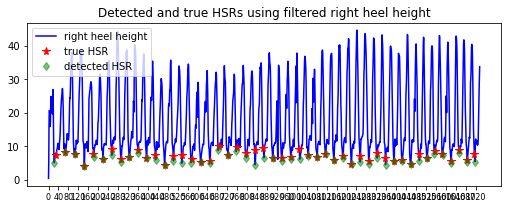

GVS_314_T_T1


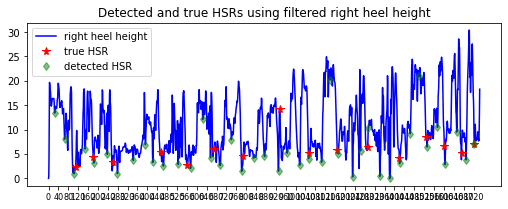

GVS_314_T_T2


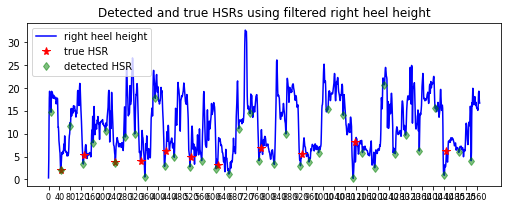

GVS_318_T_T1


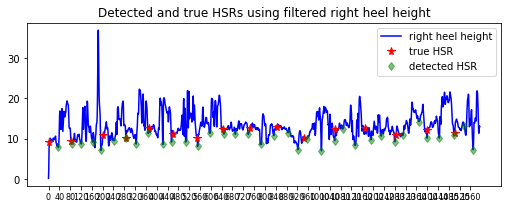

GVS_318_T_T2


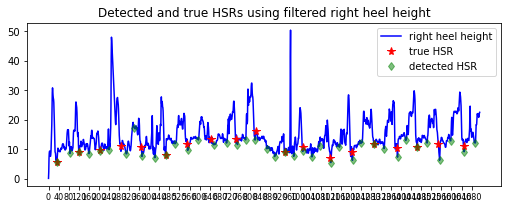

GVS_320_T_T1


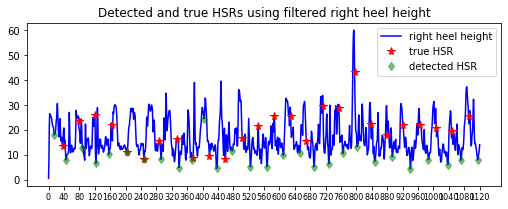

GVS_320_T_T2


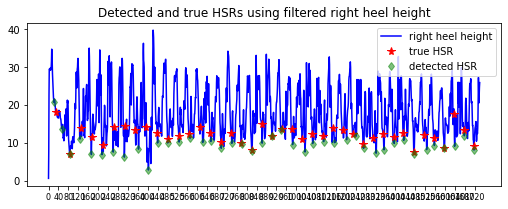

GVS_321_T_T1


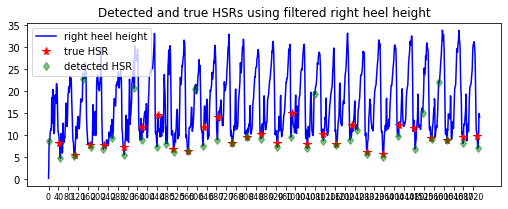

GVS_321_T_T2


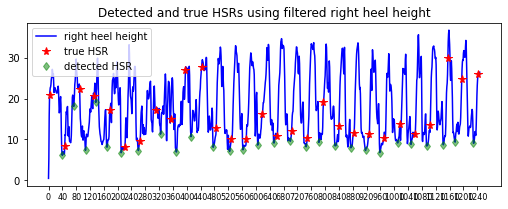

GVS_323_T_T1


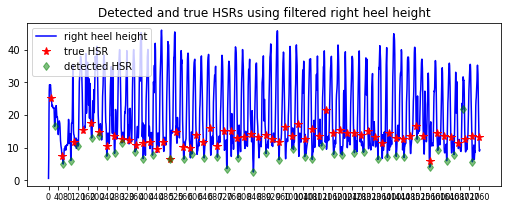

GVS_310_W_T1


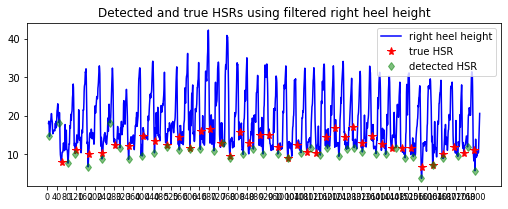

GVS_310_W_T2


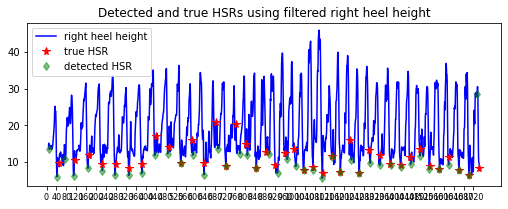

GVS_311_W_T1


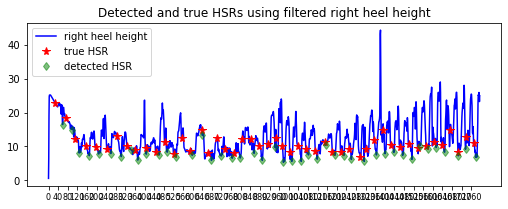

GVS_311_W_T2


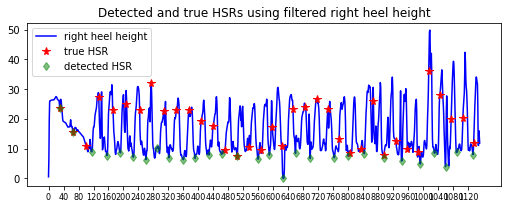

GVS_312_W_T2


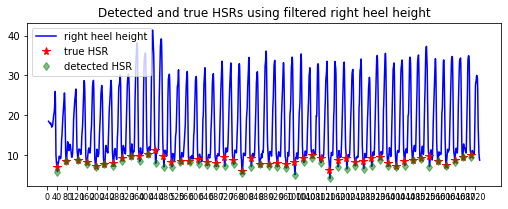

GVS_313_W_T1


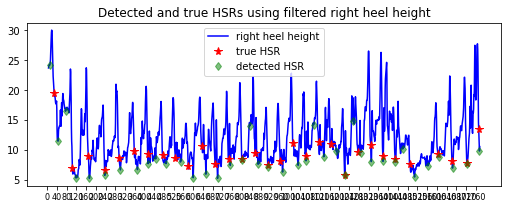

GVS_313_W_T2


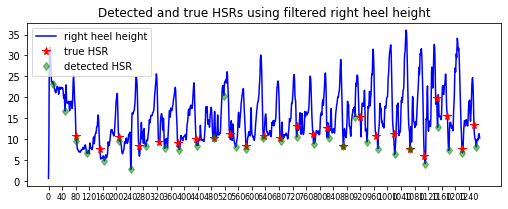

GVS_314_W_T1


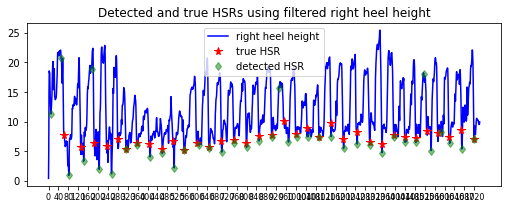

GVS_314_W_T2


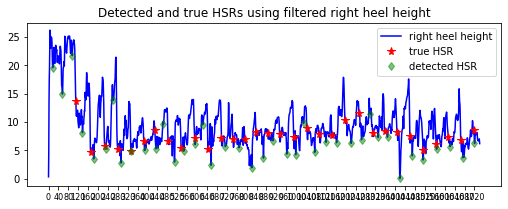

GVS_318_W_T1


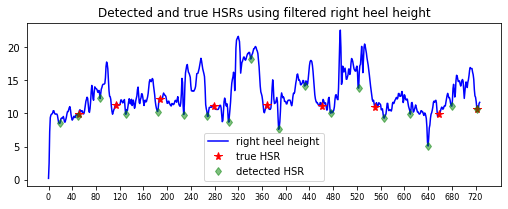

GVS_318_W_T2


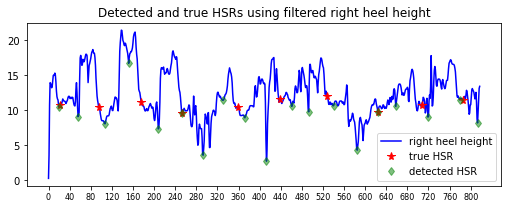

GVS_320_W_T1


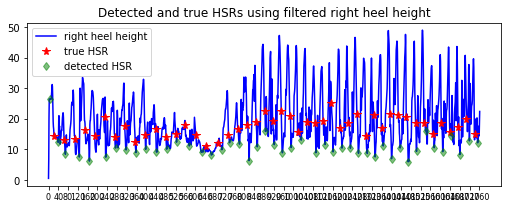

GVS_320_W_T2


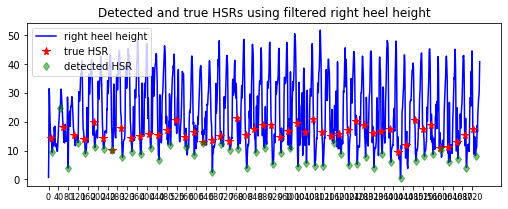

GVS_321_W_T1


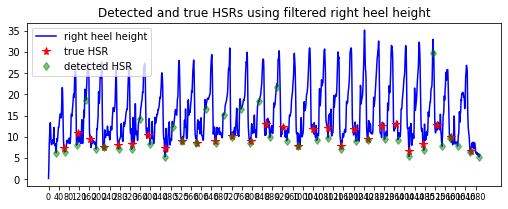

GVS_321_W_T2


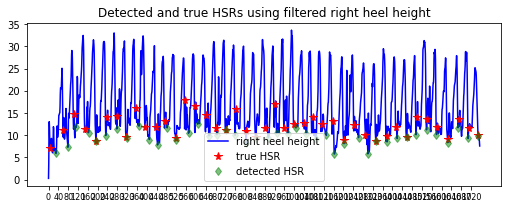

GVS_322_W_T1


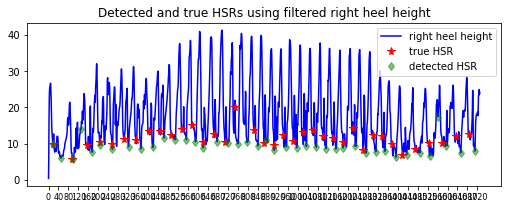

GVS_322_W_T2


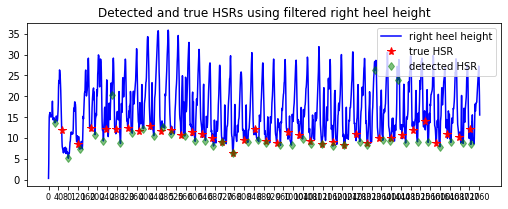

GVS_323_W_T1


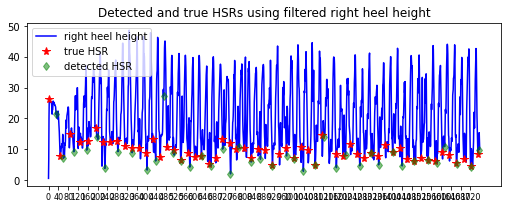

GVS_323_W_T2


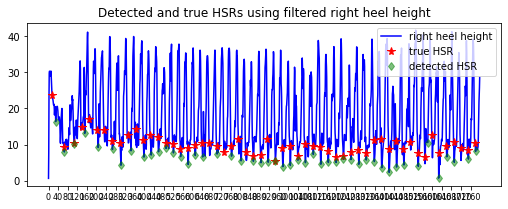

GVS_403_T_T1


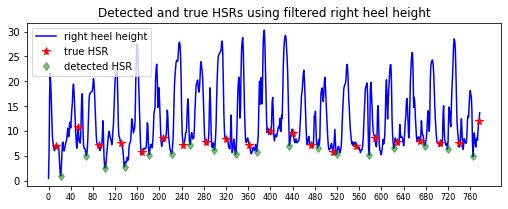

GVS_403_T_T2


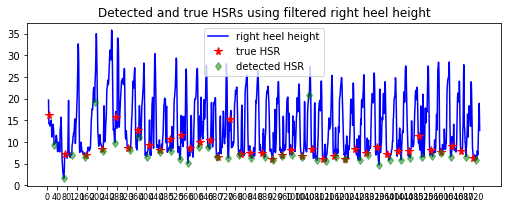

GVS_406_T_T1


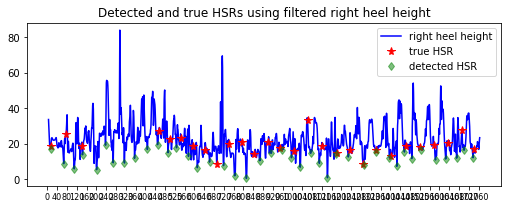

GVS_406_T_T2


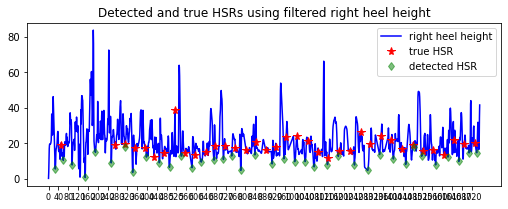

GVS_407_T_T1


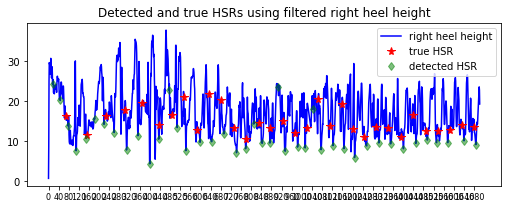

GVS_407_T_T2


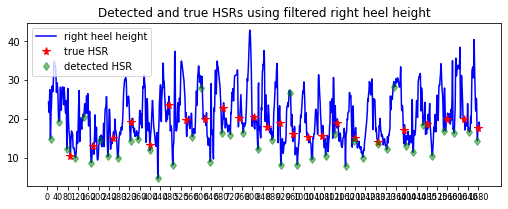

GVS_408_T_T1


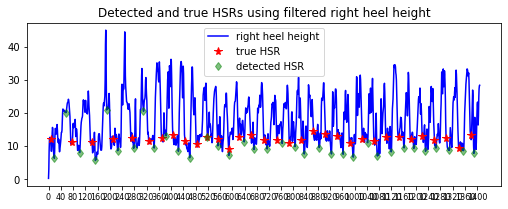

GVS_408_T_T2


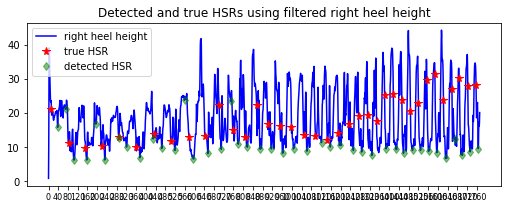

GVS_409_T_T1


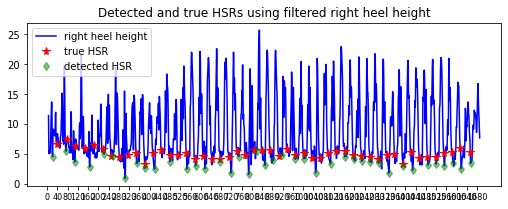

GVS_409_T_T2


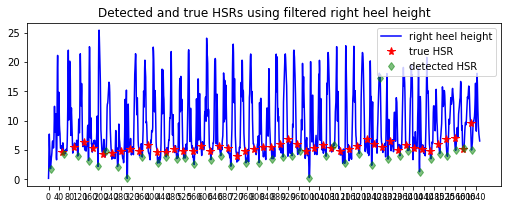

GVS_410_T_T1


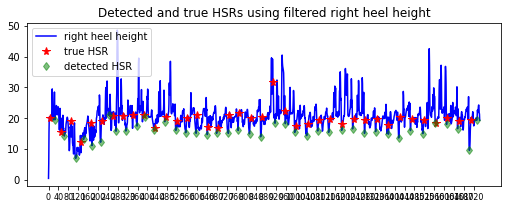

GVS_410_T_T2


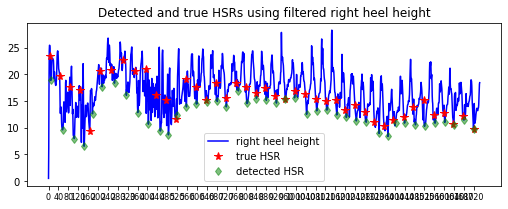

GVS_403_W_T2


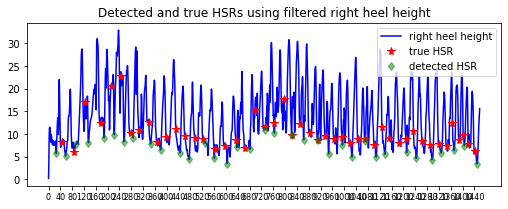

GVS_404_W_T1


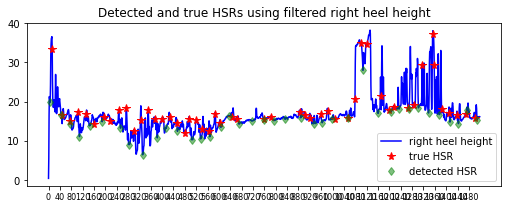

GVS_404_W_T2


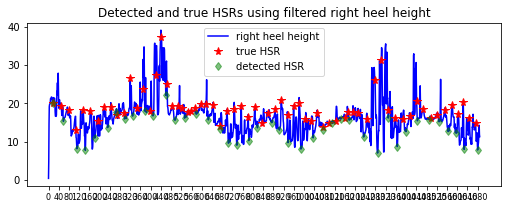

GVS_404_W_T3


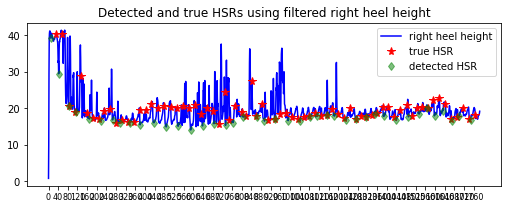

GVS_404_W_T4


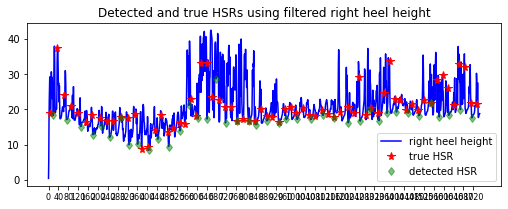

GVS_405_W_T1


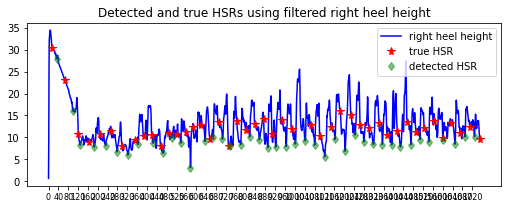

GVS_405_W_T2


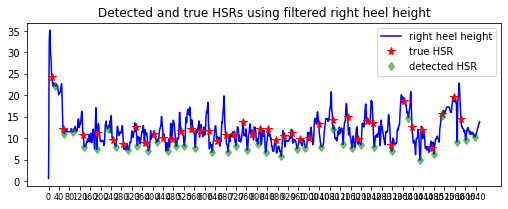

GVS_405_W_T3


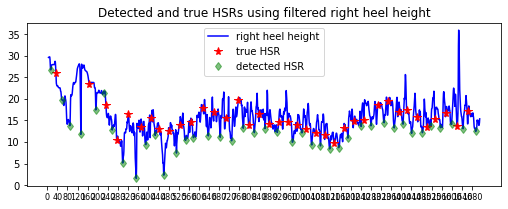

GVS_405_W_T4


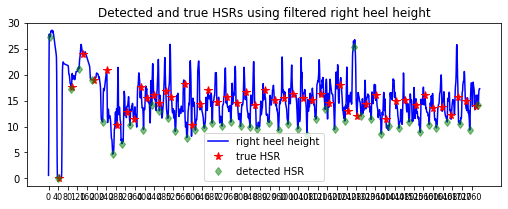

GVS_406_W_T1


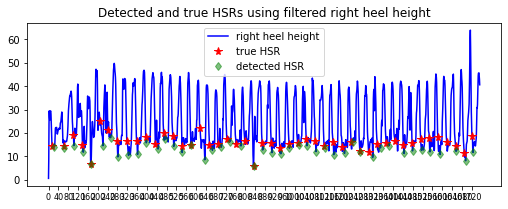

GVS_406_W_T2


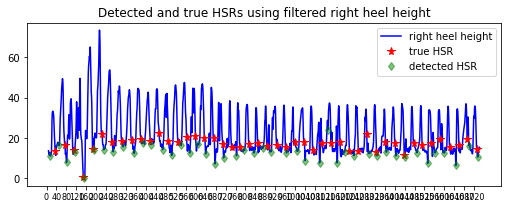

GVS_407_W_T1


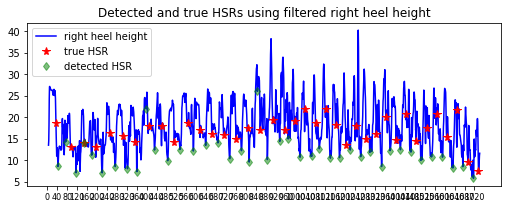

GVS_407_W_T2


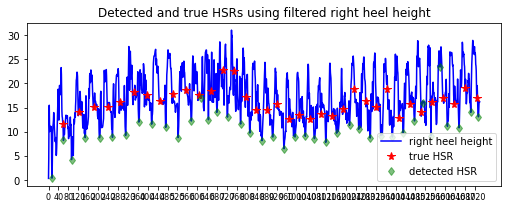

GVS_408_W_T1


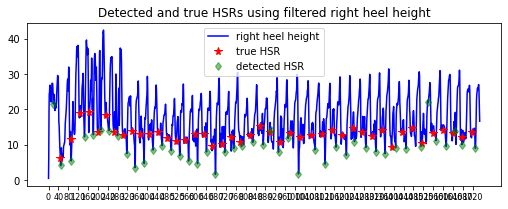

GVS_408_W_T2


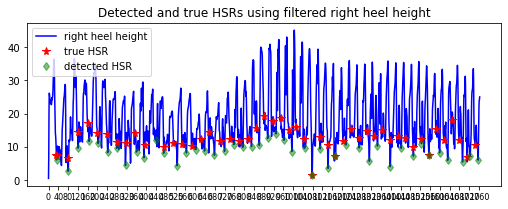

GVS_409_W_T1


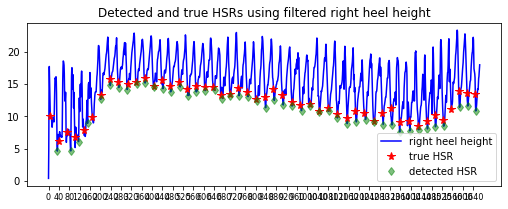

GVS_409_W_T2


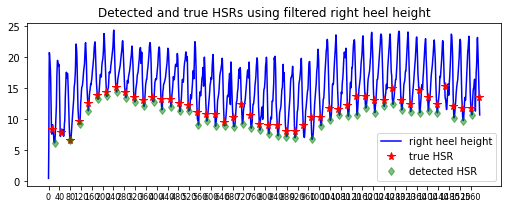

GVS_410_W_T1


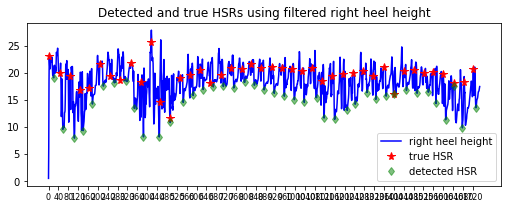

GVS_410_W_T2


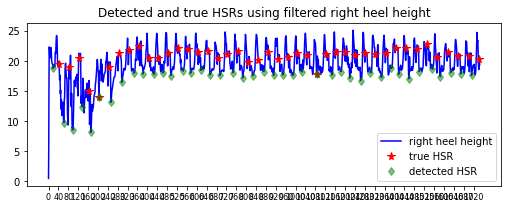

GVS_411_W_T1


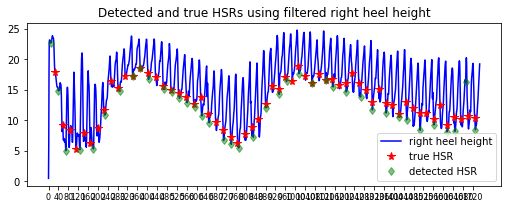

GVS_411_W_T2


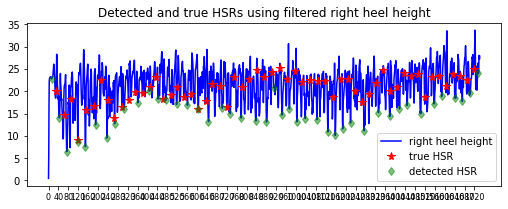

GVS_411_W_T3


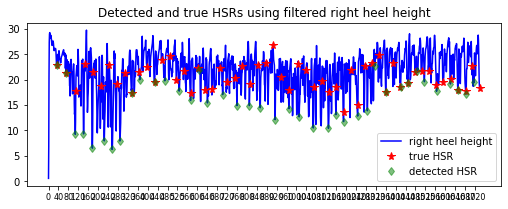

GVS_411_W_T4


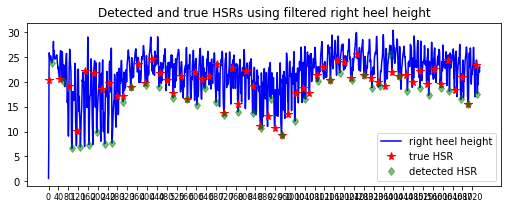

GVS_102_W_T1


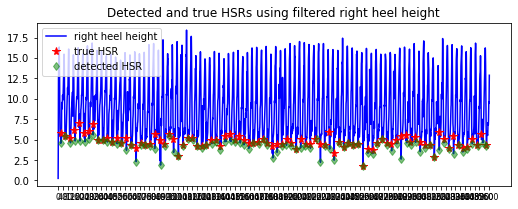

GVS_112_W_T1


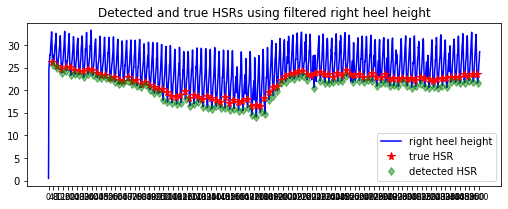

GVS_113_W_T1


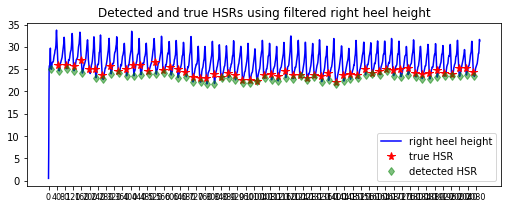

GVS_115_W_T1


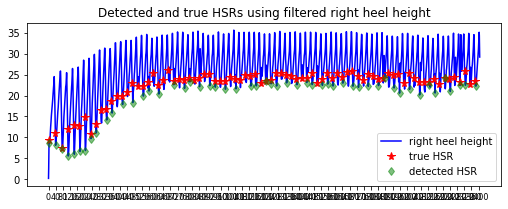

GVS_123_W_T1


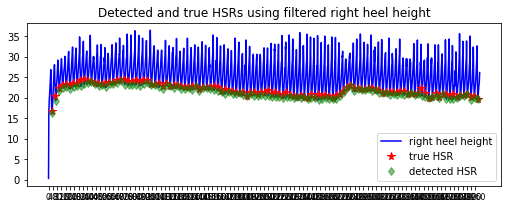

GVS_124_W_T1


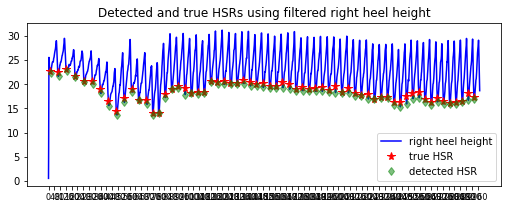

In [10]:
for cohort in cohorts:
    for trial in trials:
        merged_path = frame_path_merged+cohort+trial 
        if (os.path.exists(merged_path)):
            videos = os.listdir(merged_path)
#             print (len(videos))
            for video in videos:
                print (video)
                #Reading the ground truth HSR frames numbers
                trueHSR = open(merged_path+'\\'+video+'\\hip_height_normalized\\'+'\\HSRframes.txt').read()
                #Making a list containing ground truth HSRs out of the read file
                trueHSR_list = [int(a) for a in trueHSR.split(',')]
                count_trueHSR = len(trueHSR_list) #Count of true HSRs

                frames = glob.glob(merged_path+'\\'+video+'\\hip_height_normalized\\*.csv')
                #First, we need to sort the frames since we need frames to appear 
                #in order to detect HSRs
                sorted_frames = sorted(frames,  key=lambda name: int(name.split('\\')[-1][:-4]))
                #Dataframe to hold all 12*3 features (right hip-x, right hip-y, ...) 
                #as columns and all frames as rows for each video 
                video_features = compute_video_features(sorted_frames, labels)
                #If some frames are missing, appending those rows with NaN values 
                video_features_complete = video_features.reindex(range(video_features.index[-1]))

                #Indices for the ground truth HSR in the video_features_complete dataframe 
                #(containing NaN valued placeholders for the missing frames)
                trueHSR_indices_complete = [i for i, val in enumerate(video_features_complete.index) if val in trueHSR_list] 

                #Right heel height with missing frames encoded as NaNs
                series_complete = video_features_complete['right heel-z']
                #Computing the detected HSRs
                detectedHSR = compute_HSR(series_complete, trueHSR_indices_complete, video)
                #Saving the detected HSRs to a new .txt file
                detectedHSR_file = open('HSR_detection_figs_values\\'+ video+ '_detectedHSRs.txt', 'w') 
                detectedHSR_file.writelines(', '.join([str(x) for x in detectedHSR])) 
                detectedHSR_file.close()
                #Computing the error, absolute error and error stats for the detected and true HSR of the video
                HSR_error, HSR_abs_error, heel_error_stats = compute_error_HSR(detectedHSR, trueHSR_indices_complete)
                #Saving the errors and corresponding stats to a dataframe for error analysis 
                dataframe_error_stats.loc[len(dataframe_error_stats)] = [cohort]+[trial]+[video]+ heel_error_stats + \
                [count_trueHSR] + [len(detectedHSR)] + [HSR_error] + [HSR_abs_error]
#Saving the csv with errors for error analysis later 
rename(dataframe_error_HSR) #Renaming to have proper format of the errors file
dataframe_error_stats.to_csv('HSR_detection_figs_values\\dataframe_error_stats_HSR_identification.csv')

GVS_312_T_T1


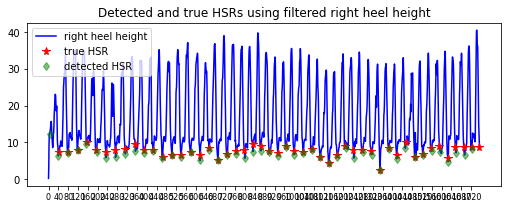

In [450]:
# #312_T_T1 is remaining
# for cohort in ['\\MS']:
#     for trial in ['\\beam_walking']:
#         merged_path = frame_path_merged+cohort+trial 
#         if (os.path.exists(merged_path)):
#             videos = os.listdir(merged_path)
# #             print (len(videos))
#             for video in videos[4:5]:
#                 print (video)
#                 #Reading the ground truth HSR frames numbers
#                 trueHSR = open(merged_path+'\\'+video+'\\hip_height_normalized\\'+'\\HSRframes.txt').read()
#                 #Making a list containing ground truth HSRs out of the read file
#                 trueHSR_list = [int(a) for a in trueHSR.split(',')]
#                 count_trueHSR = len(trueHSR_list) #Count of true HSRs

#                 frames = glob.glob(merged_path+'\\'+video+'\\hip_height_normalized\\*.csv')
#                 #First, we need to sort the frames since we need frames to appear 
#                 #in order to detect HSRs
#                 sorted_frames = sorted(frames,  key=lambda name: int(name.split('\\')[-1][:-4]))
#                 #Dataframe to hold all 12*3 features (right hip-x, right hip-y, ...) 
#                 #as columns and all frames as rows for each video 
#                 video_features = compute_video_features(sorted_frames, labels)
#                 #If some frames are missing, appending those rows with NaN values 
#                 video_features_complete = video_features.reindex(range(video_features.index[-1]))

#                 #Indices for the ground truth HSR in the video_features_complete dataframe 
#                 #(containing NaN valued placeholders for the missing frames)
#                 trueHSR_indices_complete = [i for i, val in enumerate(video_features_complete.index) if val in trueHSR_list] 

#                 #Right heel height with missing frames encoded as NaNs
#                 series_complete = video_features_complete['right heel-z']
#                 #Computing the detected HSRs
#                 detectedHSR = compute_HSR(series_complete, trueHSR_indices_complete, video)
#                 #Saving the detected HSRs to a new .txt file
#                 detectedHSR_file = open('HSR_detection_figs_values\\'+ video+ '_detectedHSRs.txt', 'w') 
#                 detectedHSR_file.writelines(', '.join([str(x) for x in detectedHSR])) 
#                 detectedHSR_file.close()
#                 #Computing the error, absolute error and error stats for the detected and true HSR of the video
#                 HSR_error, HSR_abs_error, heel_error_stats = compute_error_HSR(detectedHSR, trueHSR_indices_complete)
#                 #Saving the errors and corresponding stats to a dataframe for error analysis 
#                 dataframe_error_stats.loc[len(dataframe_error_stats)] = [cohort]+[trial]+[video]+ heel_error_stats + \
#                 [count_trueHSR] + [len(detectedHSR)] + [HSR_error] + [HSR_abs_error]
# #Saving the csv with errors for error analysis later 
# # rename(dataframe_error_HSR) #Renaming to have proper format of the errors file
# # dataframe_error_stats.to_csv('HSR_detection_figs_values\\dataframe_error_stats_HSR_identification.csv')

In [448]:
# rename(dataframe_error_stats)
# dataframe_error_stats_original = pd.read_csv('HSR_detection_figs_values\\dataframe_error_stats_HSR_identification.csv', index_col = 0)
# # display(dataframe_error_stats_original.head())
# # display(dataframe_error_stats)
# dataframe_error_stats_final = pd.concat((dataframe_error_stats_original, dataframe_error_stats), ignore_index = True)
# display(dataframe_error_stats_final)
# dataframe_error_stats_final.to_csv('HSR_detection_figs_values\\dataframe_error_stats_HSR_identification.csv')

cohort trial         video  heel_mean_error  heel_std_error  \
0      HOA    BW  GVS_212_T_T1         3.022727        6.548729   
1      HOA    BW  GVS_212_T_T2         5.044444        6.521607   
2      HOA    BW  GVS_213_T_T1         5.857143        7.639407   
3      HOA    BW  GVS_213_T_T2         4.000000        4.627595   
4      HOA    BW  GVS_214_T_T1         2.468085        6.731479   
..     ...   ...           ...              ...             ...   
103    HOA     W  GVS_115_W_T1         3.471698        1.818187   
104    HOA     W  GVS_123_W_T1         2.252101        1.131805   
105    HOA     W  GVS_124_W_T1         3.015625        1.662943   
106     MS    BW  GVS_312_T_T1        -0.204082        5.671193   
107     MS    BW  GVS_312_T_T1        -0.204082        5.671193   

     heel_abs_mean_error  heel_abs_std_error count_trueHSR count_detectedHSR  \
0               4.295455            5.794117            44                44   
1               6.111111            5.534627            45                45   
2               8.619048            4.287037            43                42   
3               4.682927            3.935077            52                41   
4               4.851064            5.279340            57                47   
..                   ...                 ...           ...               ...   
103             3.471698            1.818187            83                53   
104             2.252101            1.131805           119               119   
105             3.015625            1.662943            65                64   
106             2.081633            5.279289            49                49   
107             2.081633            5.279289            49                49   

                                            error_list  \
0    [-26, 20, 2, 3, 3, 2, 1, 2, 15, -2, 6, 11, 4, ...   
1    [-1, -21, 23, 4, 22, 4, 11, 1, 2, -2, 11, 3, 3...   
2    [-16, -13, 1, -4, 0, 17, 11, 12, 6, 8, 12, 6, ...   
3    [1, 0, 14, 8, 1, 7, -10, 12, -3, 6, 12, 8, 8, ...   
4    [-19, 19, 1, 1, -15, 1, 10, 0, 0, 2, 1, 1, 3, ...   
..                                                 ...   
103  [2, 2, 2, 3, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 7, ...   
104  [2, 3, 4, 3, 3, 3, 3, 3, 4, 3, 2, 1, 2, 4, 3, ...   
105  [5, 6, 7, 1, 1, 5, 5, 3, 5, 3, 6, 0, 4, 1, 1, ...   
106  [-38, -3, -1, 0, -3, 1, -1, 1, 2, 2, 1, -2, -1...   
107  [-38, -3, -1, 0, -3, 1, -1, 1, 2, 2, 1, -2, -1...   

                                        abs_error_list  
0    [26, 20, 2, 3, 3, 2, 1, 2, 15, 2, 6, 11, 4, 14...  
1    [1, 21, 23, 4, 22, 4, 11, 1, 2, 2, 11, 3, 3, 1...  
2    [16, 13, 1, 4, 0, 17, 11, 12, 6, 8, 12, 6, 6, ...  
3    [1, 0, 14, 8, 1, 7, 10, 12, 3, 6, 12, 8, 8, 8,...  
4    [19, 19, 1, 1, 15, 1, 10, 0, 0, 2, 1, 1, 3, 2,...  
..                                                 ...  
103  [2, 2, 2, 3, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 7, ...  
104  [2, 3, 4, 3, 3, 3, 3, 3, 4, 3, 2, 1, 2, 4, 3, ...  
105  [5, 6, 7, 1, 1, 5, 5, 3, 5, 3, 6, 0, 4, 1, 1, ...  
106  [38, 3, 1, 0, 3, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1,...  
107  [38, 3, 1, 0, 3, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1,...  

[108 rows x 11 columns]

### HSR identification error analysis 
Refer https://pubmed.ncbi.nlm.nih.gov/18657816/ for evaluation strategies 
1. Qualitative plot 
2. Distribution/histogram of error (use mean, not absolute mean) estimates 
3. Mean, SD for overall errors and analysis on HOA/MS/PD subgroups 
4. t-test for significant difference wrt to a reference error (collapse across each subject, so that we do not have repeated measures across same subject)
5. Linear mixed model trial/cohort to check differences between cohorts and trials 

In [451]:
dataframe_error_HSR = pd.read_csv('HSR_detection_figs_values\\dataframe_error_stats_HSR_identification.csv', index_col=0)
print ('Mean:\n', dataframe_error_HSR.mean())
print ('\nStandard deviation:\n', dataframe_error_HSR.std())

print ('Cohort wise grouped mean:\n')
display(dataframe_error_HSR.groupby('cohort').mean())

print ('Cohort wise grouped standard deviation:\n')
display(dataframe_error_HSR.groupby('cohort').std())

Mean:
 heel_mean_error         3.739830
heel_std_error         11.036971
heel_abs_mean_error     9.703244
heel_abs_std_error      7.390961
count_trueHSR          46.268519
count_detectedHSR      43.046296
dtype: float64

Standard deviation:
 heel_mean_error         3.636080
heel_std_error          9.397191
heel_abs_mean_error     6.622364
heel_abs_std_error      6.676307
count_trueHSR          16.860952
count_detectedHSR      12.293440
dtype: float64
Cohort wise grouped mean:



heel_mean_error  heel_std_error  heel_abs_mean_error  \
cohort                                                         
HOA            4.184236        7.576233             6.987622   
MS             2.540225       14.093200            11.529884   
PD             4.456936       11.738114            10.824994   

        heel_abs_std_error  count_trueHSR  count_detectedHSR  
cohort                                                        
HOA               6.087438      55.342105          49.342105  
MS                9.225673      35.314286          38.314286  
PD                6.971504      47.371429          40.942857

Cohort wise grouped standard deviation:



heel_mean_error  heel_std_error  heel_abs_mean_error  \
cohort                                                         
HOA            3.348573        8.364474             4.489679   
MS             4.287443       10.916700             8.626556   
PD             2.965055        7.686923             5.356391   

        heel_abs_std_error  count_trueHSR  count_detectedHSR  
cohort                                                        
HOA               7.053146      16.929546          16.791691  
MS                7.055284      14.492942           8.577575  
PD                5.551161      12.487843           4.826050

In [452]:
#Attaching the subject ID to make sure we deal with repeated observations
#per subject before performing the t-test
dataframe_error_HSR['PID'] = [i[4:7] for i in dataframe_error_HSR['video']]

In [453]:
HSR_error_over_subjects = dataframe_error_HSR[['PID', 'heel_mean_error']].groupby('PID').mean().values
HSR_error_over_subjects_in_seconds = [i/30.0 for i in HSR_error_over_subjects]
print (np.mean(HSR_error_over_subjects_in_seconds), np.std(HSR_error_over_subjects_in_seconds))

#t-test to check if the mean error in seconds for computing HSRs is significantly different from 0
print (stats.ttest_1samp(HSR_error_over_subjects_in_seconds, 0))
#Since the p-value<<0.05, we reject the null hypothesis that mean = 0 seconds, 
#hence we conclude that mean is significantly different than 0 seconds. 

0.1229388747075661 0.06994159006400605
Ttest_1sampResult(statistic=array([9.9432583]), pvalue=array([2.60530783e-11]))


In [415]:
def plot_true_HSR_paper(signal, index, HSRindices, video, detectedHSR):
#     print (type(signal), type(index))
    signal-=5
#     index = index[1360:2000]
#     signal = signal[index]
#     print (type(signal), type(index))
    fig= plt.figure(figsize = (6.5, 3))
    ax1 = fig.add_subplot(111)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
#     ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
    ax1.plot(index, signal, color = 'k', ls='solid', linewidth = 2, alpha = 1) #label = 'right heel\'s height', 
    ax1.plot(index[HSRindices], signal[HSRindices], '*', color = 'r', ms = 18, alpha = 1, label = 'true HSR')
    ax1.plot(index[detectedHSR], signal[detectedHSR], 'D', ms = 10, mfc = 'lawngreen', alpha = 0.65, \
             label = 'detected HSR')
    plt.xticks(index[0::40], fontsize = 13)
    plt.yticks(fontsize = 14)
    plt.ylabel('Right heel\'s height (cm)', fontsize = 13.2)
    plt.xlabel('Frame number', fontsize = 14)
    plt.legend(fontsize = 13.2, loc = 'top right')
#     plt.title('Filtered right heel\'s height', fontsize = 15)
    plt.tight_layout()
#     plt.savefig('HSR_detection_figs_values\\'+ 'filtered_right_heel_z_paper.png', dpi = 300)
    plt.show()

In [416]:
#Quantitative plot
#We might need to annotate the ground truth HSR frames in the plot 
#https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
%matplotlib widget
for video in ['MS\\walking\\GVS_312_W_T2']:
    print (video)
    trueHSR = open(frame_path_merged+video+'\\hip_height_normalized\\'+'\\HSRframes.txt').read()
    trueHSR_list = [int(a) for a in trueHSR.split(',')]
    frames = glob.glob(frame_path_merged+video+'\\hip_height_normalized\\*.csv')
    sorted_frames = sorted(frames,  key=lambda name: int(name.split('\\')[-1][:-4]))
    video_features = compute_video_features(sorted_frames, labels)
    video_features_complete = video_features.reindex(range(video_features.index[-1]))
    trueHSR_indices_complete = [i for i, val in enumerate(video_features_complete.index) if val in trueHSR_list] 
    series_complete = video_features_complete['right heel-z']
    #Computing the detected HSRs
    series_complete.interpolate(method='values', inplace = True)
    a = signal.firwin(5, cutoff = 0.3, window = "hamming") 
    fir_series = signal.lfilter(a, [1.0], series_complete.values)
    detectedHSR, _ = find_peaks(-fir_series, distance = 30) 
    plot_true_HSR_paper(fir_series, series_complete.index, trueHSR_indices_complete, video, detectedHSR)


MS\walking\GVS_312_W_T2


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Count of strides: 4649


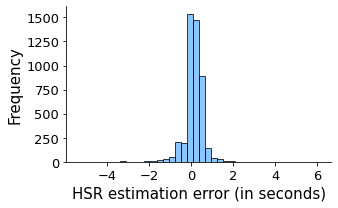

In [454]:
#Computing the concatenated list of 
error_concatenated_list = [int(i) for j in range(len(dataframe_error_HSR['error_list'])) for i in str(dataframe_error_HSR['error_list'][j])[1:-1].split(',')]
print ('Count of strides:', len(error_concatenated_list))
error_concatenated_list_in_seconds = [i/30.0 for i in error_concatenated_list]

fig = plt.figure(figsize = (4.8, 3))
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
plt.hist(error_concatenated_list_in_seconds, color = '#66b3ff', bins = 40, histtype='bar', ec='black', alpha = 0.75, \
        rwidth = 100, linewidth = 1)
# plt.title('Frequency distribution of HSR estimation errors', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('HSR estimation error (in seconds)', fontsize = 15)
plt.xticks(fontsize = 13) 
plt.yticks(fontsize = 13) 
plt.ylim()
plt.tight_layout()
plt.savefig('HSR_detection_figs_values\\histogram_HSRerrors.png', dpi = 300)
plt.show()

### Downsample with smoothing to define fixed shape input tensor for models
1. The downsampled stride .csvs are stored in C:\Users\purpl\Box\Gait Video Project\GaitVideoData\video\downsampled_strides\ with a unique identifier as '(video_name)_(stride_number).csv', for example, GVS_212_W_T1_23.csv. Each downsample stride's .csv has 20 rows for 20 downsampled frames and 36 columns for 36 features.  
2. The original length stride .csvs are in C:\Users\purpl\Box\Gait Video Project\GaitVideoData\video\original_length_strides\ with the same unique identifier as '(video_name)_(stride_number).csv', for example, GVS_212_W_T1_23.csv. Each original length stride's .csv has n rows for n frames in the stride and 36 columns for 36 features. Note that we must have NaN rows for missing frames in the stride, since we must keep track of unevenly sampled frames in between.
3. Basically, the downsampled stride's .csv is a windowed mean version (with 20 windows) of the original length stride's .csv.
4. We create a labels.csv with columns for cohort (HOA/MS/PD), trial (walking/beam walking), scenario (W/WT/T/TT), video name (GVS_212_W_T1), PID (212), stride number (23), unique identifier for each stride (GVS_212_W_T1_23), original frame count in a stride (including the missing frames) to represent the speed of the subject as a feature and label (0 - HOA/1-MS/2-PD).
5. So the idea is to use this file labels.csv (and specifically the unique identifier column) to decide the identifiers for the training/testing sets/folds and then pull out the .csvs of the same name as samples and pull the from the label column of the labels.csv the labels of the corresponding identifier strides. 
6. Once all the downsampled strides are created, we check if any of strides have missing frames. If they do, we use the frames from the same strides and linear interpolation to fill us these missing frames in any downsampled strides. Also note that only the corresponding marker i.e. say right hip's x is used to filled it's relative feature values in the missig frame/frames of the stride. 

In [395]:
## Run only once to create directories 
#To create all directories for saving the downsampled hip height normalized multi view merged data files 
# for cohort in cohorts:
#     for trial in trials:   
#         merged_path = frame_path_merged+cohort+trial 
#         if (os.path.exists(merged_path)):
#             videos = os.listdir(merged_path)
# #             print (len(videos))
#             for video in videos:         
#                 if not os.path.exists(downsample_path+cohort+trial+'\\'+video):
#                     os.makedirs(downsample_path+cohort+trial+'\\'+video)

In [396]:
#Path for original length strides (including the NaN frames in a stride for missing samples)
original_strides_path = 'C:\\Users\\purpl\\Box\\Gait Video Project\\GaitVideoData\\video\\original_length_strides\\'
#Path for downsampled strides (each file has 20 downsampled/smoothed frames and 36 features)
downsampled_strides_path = 'C:\\Users\\purpl\\Box\\Gait Video Project\\GaitVideoData\\video\\downsampled_strides\\'
#Path for storing the labels.csv file with log of each stride 
labels_path = 'C:\\Users\\purpl\\Box\\Gait Video Project\\GaitVideoData\\video\\'

#Columns for labels.csv include cohort (HOA/MS/PD), trial (walking/beam walking), scenario (W/WT/T/TT), 
#video name (GVS_212_W_T1), PID (212), stride number (23), unique identifier for each stride (GVS_212_W_T1_23), 
#original frame count in a stride (including the missing frames) to represent the speed of 
#the subject as a feature and label (0 - HOA/1-MS/2-PD)
#Note that scenario will be filled later
labels_col = ['cohort', 'trial', 'scenario', 'video', 'PID', 'stride_number', 'key', 'frame_count', 'label']
#Dataframe for labels.csv
labels_df = pd.DataFrame (columns = labels_col)
#Keeping 20 frames for each stride while downsampling
downsampled_frames_per_stride = 20

In [398]:
#Use mean with disjoint windows to downsample while smoothing 
#Make sure to preserve count of frames in a stride before smoothing to add as a feature 

for cohort in cohorts:
    label = define_label(cohort) #Defining the label as 0/1/2 depending on cohort
    for trial in trials:
        merged_path = frame_path_merged+cohort+trial 
        if (os.path.exists(merged_path)):
            videos = os.listdir(merged_path)
#             print (len(videos))
            for video in videos:
                start_time = time.time()
                print (video)
                #File with detected HSRs for the video
                detectedHSR_file = open('HSR_detection_figs_values\\'+ video+ '_detectedHSRs.txt').read()
                #List of detected HSRs
                detectedHSRs = [int(i) for i in detectedHSR_file.split(',')] 
                frames = glob.glob(merged_path+'\\'+video+'\\hip_height_normalized\\*.csv')
                #First, we need to sort the frames since we need frames to appear 
                #in order to make downsamples from detected HSRs
                sorted_frames = sorted(frames,  key=lambda name: int(name.split('\\')[-1][:-4]))
                #Dataframe to hold all 12*3 features (right hip-x, right hip-y, ...) 
                #as columns and all frames as rows for each video 
                video_features = compute_video_features(sorted_frames, labels)
                #If some frames are missing, appending those rows with NaN values 
                video_features_complete = video_features.reindex(range(video_features.index[-1]))
                
                #For len(detectedHSRs) HSRs, we have len(detectedHSRs)-1 strides. 
                for HSR_idx in range(0, len(detectedHSRs)-1): #Looping through each stride of the walk
                    #Unique key for each naming each stride 
                    unique_stride_key = video+'_'+str(HSR_idx+1)
                    #Collecting the frames in each stride (including the frame at idx HSR but not (idx+1) HSR)
                    #It included NaNs for the missing frames in a stride
                    stride_features = video_features_complete[detectedHSRs[HSR_idx]:detectedHSRs[HSR_idx+1]]
                    #Saving the original length stride with the unique key in the name
                    stride_features.to_csv(original_strides_path+unique_stride_key+'.csv')
                    
                    #Creating the downsampled stride with 20 frames for each stride containg n frames
                    downsampled_stride = pd.DataFrame(columns = stride_features.columns) 
                    #Creating an approximately even splits of frames to divide n frames in a stride to 20 
                    #downsampled frames
                    splits = np.array_split(stride_features.index, downsampled_frames_per_stride)
                    for split in splits:
                        #We do the windowed mean of each split of frames to get the downsampled frame
                        downsampled_stride.loc[len(downsampled_stride)] = stride_features.loc[split].mean()
                    #Saving the downsampled stride with 20*36 with the unique key in the name
                    downsampled_stride.to_csv(downsampled_strides_path+unique_stride_key+'.csv')
                    
                    #Creating the labels file row for each stride saved 
                    labels_df.loc[len(labels_df)] = [cohort] + [trial] + ['W'] + [video] + [video[4:7]] +\
                    [str(HSR_idx+1)] + [unique_stride_key] + [len(stride_features)] + [label]
                print ('Time for ', video, 'is: ', time.time()-start_time)
                
#Saving the file with complete log as labels.csv
rename(labels_df)
labels_df.to_csv(labels_path+'labels.csv')
#Note that scenario will be filled later

GVS_212_T_T1
Time for  GVS_212_T_T1 is:  48.55868864059448
GVS_212_T_T2
Time for  GVS_212_T_T2 is:  42.0511634349823
GVS_213_T_T1
Time for  GVS_213_T_T1 is:  55.817229986190796
GVS_213_T_T2
Time for  GVS_213_T_T2 is:  35.17064833641052
GVS_214_T_T1
Time for  GVS_214_T_T1 is:  40.12201809883118
GVS_214_T_T2
Time for  GVS_214_T_T2 is:  38.33488416671753
GVS_215_T_T1
Time for  GVS_215_T_T1 is:  40.03301286697388
GVS_215_T_T2
Time for  GVS_215_T_T2 is:  40.5480523109436
GVS_216_T_T1
Time for  GVS_216_T_T1 is:  37.71484017372131
GVS_216_T_T2
Time for  GVS_216_T_T2 is:  39.100939989089966
GVS_217_T_T1
Time for  GVS_217_T_T1 is:  66.95307874679565
GVS_217_T_T2
Time for  GVS_217_T_T2 is:  39.80799436569214
GVS_218_T_T1
Time for  GVS_218_T_T1 is:  44.794370889663696
GVS_218_T_T2
Time for  GVS_218_T_T2 is:  43.76029133796692
GVS_219_T_T1
Time for  GVS_219_T_T1 is:  40.38803791999817
GVS_219_T_T2
Time for  GVS_219_T_T2 is:  40.73306727409363
GVS_212_W_T1
Time for  GVS_212_W_T1 is:  40.59105300903

In [457]:
# #312_T_T1 is remaining
# #Use mean with disjoint windows to downsample while smoothing 
# #Make sure to preserve count of frames in a stride before smoothing to add as a feature 

# for cohort in ['\\MS']:
#     label = define_label(cohort) #Defining the label as 0/1/2 depending on cohort
#     for trial in ['\\beam_walking']:
#         merged_path = frame_path_merged+cohort+trial 
#         if (os.path.exists(merged_path)):
#             videos = os.listdir(merged_path)
# #             print (len(videos))
#             for video in videos[4:5]:
#                 start_time = time.time()
#                 print (video)
#                 #File with detected HSRs for the video
#                 detectedHSR_file = open('HSR_detection_figs_values\\'+ video+ '_detectedHSRs.txt').read()
#                 #List of detected HSRs
#                 detectedHSRs = [int(i) for i in detectedHSR_file.split(',')] 
#                 frames = glob.glob(merged_path+'\\'+video+'\\hip_height_normalized\\*.csv')
#                 #First, we need to sort the frames since we need frames to appear 
#                 #in order to make downsamples from detected HSRs
#                 sorted_frames = sorted(frames,  key=lambda name: int(name.split('\\')[-1][:-4]))
#                 #Dataframe to hold all 12*3 features (right hip-x, right hip-y, ...) 
#                 #as columns and all frames as rows for each video 
#                 video_features = compute_video_features(sorted_frames, labels)
#                 #If some frames are missing, appending those rows with NaN values 
#                 video_features_complete = video_features.reindex(range(video_features.index[-1]))
                
#                 #For len(detectedHSRs) HSRs, we have len(detectedHSRs)-1 strides. 
#                 for HSR_idx in range(0, len(detectedHSRs)-1): #Looping through each stride of the walk
#                     #Unique key for each naming each stride 
#                     unique_stride_key = video+'_'+str(HSR_idx+1)
#                     #Collecting the frames in each stride (including the frame at idx HSR but not (idx+1) HSR)
#                     #It included NaNs for the missing frames in a stride
#                     stride_features = video_features_complete[detectedHSRs[HSR_idx]:detectedHSRs[HSR_idx+1]]
#                     #Saving the original length stride with the unique key in the name
#                     stride_features.to_csv(original_strides_path+unique_stride_key+'.csv')
                    
#                     #Creating the downsampled stride with 20 frames for each stride containg n frames
#                     downsampled_stride = pd.DataFrame(columns = stride_features.columns) 
#                     #Creating an approximately even splits of frames to divide n frames in a stride to 20 
#                     #downsampled frames
#                     splits = np.array_split(stride_features.index, downsampled_frames_per_stride)
#                     for split in splits:
#                         #We do the windowed mean of each split of frames to get the downsampled frame
#                         downsampled_stride.loc[len(downsampled_stride)] = stride_features.loc[split].mean()
#                     #Saving the downsampled stride with 20*36 with the unique key in the name
#                     downsampled_stride.to_csv(downsampled_strides_path+unique_stride_key+'.csv')
                    
#                     #Creating the labels file row for each stride saved 
#                     labels_df.loc[len(labels_df)] = [cohort] + [trial] + ['W'] + [video] + [video[4:7]] +\
#                     [str(HSR_idx+1)] + [unique_stride_key] + [len(stride_features)] + [label]
#                 print ('Time for ', video, 'is: ', time.time()-start_time)
                
# #Saving the file with complete log as labels.csv
# rename(labels_df)
# # labels_df.to_csv(labels_path+'labels.csv')
# #Note that scenario will be filled later

GVS_312_T_T1
Time for  GVS_312_T_T1 is:  28.660163402557373


In [488]:
# labels_df_correct = labels_df.drop_duplicates().reset_index()
# labels_df_correct.to_csv(labels_path+'labels.csv')

### Filling up the missing frame values in the downsampled strides using linear interpolation from frames of the same stride

In [458]:
#Check that the downsampled strides have no NaN frames/ missing values 
#If the downsampled stride does have a missing frame, we use linear interpolation using the values of the frames 
#from the same stride to fill up this missing frame
downsampled_strides = os.listdir(downsampled_strides_path)
total_nan_files = 0
for stride in downsampled_strides: #Looping through all strides 
    #Reading the downsampled stride
    downsampled_stride = pd.read_csv(downsampled_strides_path+stride, index_col= 0)
    #Checking if a NaN is present in the current stride
    nan_present = downsampled_stride.isna().sum().sum() #nan_absent = 0 if no NaN is found in the current file
    if (nan_present>0): #If a NaN is found in the current file, it prints the file
        print (stride)
#         display(downsampled_stride)
        total_nan_files+=1
        #If NaNs are present, we use the frames of the same stride and linear interpolation to fill up the current 
        #missing stride frame/frames 
        #Note that right hip x is used to fill right hip x and so on i.e. only the corresponding feature is used '
        #to fill up the missing frames' relative feature
        downsampled_stride.interpolate(method='values', inplace = True)
        #We replace with the new file 
        downsampled_stride.to_csv(downsampled_strides_path+stride)
#         display(downsampled_stride)
print ('Total files with NaNs: ',  total_nan_files)

GVS_312_T_T1_35.csv
GVS_312_T_T1_37.csv
Total files with NaNs:  2


In [413]:
#If some strides still have NaNs means that either the first frame in the stride was missing or the last frame in 
#the stride was missing, hence we use forward/backward linear interpolation to fill up those cases
downsampled_strides = os.listdir(downsampled_strides_path)
total_nan_files = 0
for stride in downsampled_strides: #Looping through all strides 
    #Reading the downsampled stride
    downsampled_stride = pd.read_csv(downsampled_strides_path+stride, index_col= 0)
    #Checking if a NaN is present in the current stride
    nan_present = downsampled_stride.isna().sum().sum() #nan_absent = 0 if no NaN is found in the current file
    if (nan_present>0): #If a NaN is found in the current file, it prints the file
        print (stride)
#         display(downsampled_stride)
        total_nan_files+=1
        #If NaNs are present, we use the frames of the same stride and linear interpolation to fill up the current 
        #missing stride frame/frames 
        #Note that right hip x is used to fill right hip x and so on i.e. only the corresponding feature is used '
        #to fill up the missing frames' relative feature
        downsampled_stride.interpolate(method='linear',  limit_direction = 'both', inplace = True)
        #We replace with the new file 
        downsampled_stride.to_csv(downsampled_strides_path+stride)
#         display(downsampled_stride)
print ('Total files with NaNs: ',  total_nan_files)

GVS_218_T_T1_4.csv
GVS_218_W_T1_4.csv
GVS_218_W_T1_6.csv
GVS_219_W_T1_3.csv
GVS_312_T_T2_48.csv
GVS_320_W_T1_1.csv
GVS_320_W_T2_25.csv
GVS_405_W_T1_14.csv
GVS_405_W_T1_17.csv
GVS_405_W_T1_28.csv
GVS_405_W_T4_2.csv
GVS_405_W_T4_5.csv
GVS_406_T_T1_39.csv
GVS_406_T_T2_17.csv
GVS_406_W_T2_29.csv
GVS_406_W_T2_5.csv
GVS_407_T_T1_22.csv
GVS_407_T_T2_23.csv
GVS_407_T_T2_37.csv
GVS_409_T_T1_36.csv
Total files with NaNs:  20


In [459]:
#If some strides still have NaNs means that either the first frame in the stride was missing or the last frame in 
#the stride was missing, hence we use forward/backward linear interpolation to fill up those cases
downsampled_strides = os.listdir(downsampled_strides_path)
total_nan_files = 0
for stride in downsampled_strides: #Looping through all strides 
    #Reading the downsampled stride
    downsampled_stride = pd.read_csv(downsampled_strides_path+stride, index_col= 0)
    #Checking if a NaN is present in the current stride
    nan_present = downsampled_stride.isna().sum().sum() #nan_absent = 0 if no NaN is found in the current file
    if (nan_present>0): #If a NaN is found in the current file, it prints the file
        print (stride)
#         display(downsampled_stride)
        total_nan_files+=1
#         display(downsampled_stride)
print ('Total files with NaNs: ',  total_nan_files)

Total files with NaNs:  0


### Filling up the scenario column in labels.csv specifying whether the stride belongs to the trial of W: walking, WT: walking while talking, SLW: straight line walking or SLWT: straight line walking while talking. 

In [489]:
labels_file = pd.read_csv(labels_path+'labels.csv', index_col=0)
display(labels_file.head())
print (len(labels_file.video.unique()), labels_file.video.unique())
#We have 107 videos with 4493 strides in total

index cohort trial scenario         video  PID  stride_number  \
0      0    HOA    BW        W  GVS_212_T_T1  212              1   
1      1    HOA    BW        W  GVS_212_T_T1  212              2   
2      2    HOA    BW        W  GVS_212_T_T1  212              3   
3      3    HOA    BW        W  GVS_212_T_T1  212              4   
4      4    HOA    BW        W  GVS_212_T_T1  212              5   

              key  frame_count  label  
0  GVS_212_T_T1_1           46      0  
1  GVS_212_T_T1_2           39      0  
2  GVS_212_T_T1_3           56      0  
3  GVS_212_T_T1_4           53      0  
4  GVS_212_T_T1_5           44      0

107 ['GVS_212_T_T1' 'GVS_212_T_T2' 'GVS_213_T_T1' 'GVS_213_T_T2'
 'GVS_214_T_T1' 'GVS_214_T_T2' 'GVS_215_T_T1' 'GVS_215_T_T2'
 'GVS_216_T_T1' 'GVS_216_T_T2' 'GVS_217_T_T1' 'GVS_217_T_T2'
 'GVS_218_T_T1' 'GVS_218_T_T2' 'GVS_219_T_T1' 'GVS_219_T_T2'
 'GVS_212_W_T1' 'GVS_212_W_T2' 'GVS_213_W_T1' 'GVS_213_W_T2'
 'GVS_214_W_T1' 'GVS_214_W_T2' 'GVS_215_W_T1' 'GVS_215_W_T2'
 'GVS_216_W_T1' 'GVS_216_W_T2' 'GVS_217_W_T1' 'GVS_217_W_T2'
 'GVS_218_W_T1' 'GVS_218_W_T2' 'GVS_219_W_T1' 'GVS_219_W_T2'
 'GVS_310_T_T1' 'GVS_310_T_T2' 'GVS_311_T_T1' 'GVS_311_T_T2'
 'GVS_312_T_T2' 'GVS_314_T_T1' 'GVS_314_T_T2' 'GVS_318_T_T1'
 'GVS_318_T_T2' 'GVS_320_T_T1' 'GVS_320_T_T2' 'GVS_321_T_T1'
 'GVS_321_T_T2' 'GVS_323_T_T1' 'GVS_310_W_T1' 'GVS_310_W_T2'
 'GVS_311_W_T1' 'GVS_311_W_T2' 'GVS_312_W_T2' 'GVS_313_W_T1'
 'GVS_313_W_T2' 'GVS_314_W_T1' 'GVS_314_W_T2' 'GVS_318_W_T1'
 'GVS_318_W_T2' 'GVS_320_W_T1' 'GVS_320_W_T2' 'GVS_321_W_T1'
 'GVS_321_W_T2' 'GVS_322_W_T1' 'GVS_322_W_T2' 'GVS_323_W_T1'
 'GVS_323_W_T2' 'GVS

In [491]:
#Dictionary representing the scenario W/WT/SLW/SLWT for each video 
scenario_dict = {'GVS_212_T_T1': 'SLWT', 'GVS_212_T_T2': 'SLW', 'GVS_213_T_T1': 'SLWT', 'GVS_213_T_T2': 'SLW',\
 'GVS_214_T_T1': 'SLW', 'GVS_214_T_T2': 'SLWT',  'GVS_215_T_T1': 'SLWT', 'GVS_215_T_T2': 'SLW', \
 'GVS_216_T_T1': 'SLWT', 'GVS_216_T_T2': 'SLW', 'GVS_217_T_T1': 'SLW', 'GVS_217_T_T2': 'SLWT', \
 'GVS_218_T_T1': 'SLW', 'GVS_218_T_T2': 'SLWT', 'GVS_219_T_T1': 'SLWT', 'GVS_219_T_T2': 'SLW', \
 'GVS_212_W_T1': 'WT', 'GVS_212_W_T2': 'W', 'GVS_213_W_T1': 'W', 'GVS_213_W_T2': 'WT', \
 'GVS_214_W_T1': 'W', 'GVS_214_W_T2': 'WT', 'GVS_215_W_T1': 'W', 'GVS_215_W_T2': 'WT', \
 'GVS_216_W_T1': 'WT', 'GVS_216_W_T2': 'W', 'GVS_217_W_T1': 'W', 'GVS_217_W_T2': 'WT', \
 'GVS_218_W_T1': 'WT', 'GVS_218_W_T2': 'W', 'GVS_219_W_T1': 'WT', 'GVS_219_W_T2': 'W', \
 'GVS_310_T_T1': 'SLW', 'GVS_310_T_T2': 'SLWT', 'GVS_311_T_T1': 'SLWT', 'GVS_311_T_T2': 'SLW', \
 'GVS_312_T_T1': 'SLWT', 'GVS_312_T_T2': 'SLW', 'GVS_314_T_T1': 'SLW', 'GVS_314_T_T2': 'SLWT', 'GVS_318_T_T1': 'SLWT',\
 'GVS_318_T_T2': 'SLW', 'GVS_320_T_T1': 'SLW', 'GVS_320_T_T2': 'SLWT', 'GVS_321_T_T1': 'SLWT', \
 'GVS_321_T_T2': 'SLW', 'GVS_323_T_T1': 'SLW', 'GVS_310_W_T1': 'W', 'GVS_310_W_T2': 'WT',\
 'GVS_311_W_T1': 'W', 'GVS_311_W_T2': 'WT', 'GVS_312_W_T2': 'W', 'GVS_313_W_T1': 'W', \
 'GVS_313_W_T2': 'WT', 'GVS_314_W_T1': 'W', 'GVS_314_W_T2': 'WT', 'GVS_318_W_T1': 'W', \
 'GVS_318_W_T2': 'WT', 'GVS_320_W_T1': 'W', 'GVS_320_W_T2': 'WT', 'GVS_321_W_T1': 'W', \
 'GVS_321_W_T2': 'WT', 'GVS_322_W_T1': 'WT', 'GVS_322_W_T2': 'W', 'GVS_323_W_T1': 'W', \
 'GVS_323_W_T2': 'WT', 'GVS_403_T_T1': 'SLW', 'GVS_403_T_T2': 'SLWT', 'GVS_406_T_T1': 'SLWT', \
 'GVS_406_T_T2': 'SLW', 'GVS_407_T_T1': 'SLWT', 'GVS_407_T_T2': 'SLW', 'GVS_408_T_T1': 'SLW', \
 'GVS_408_T_T2': 'SLWT', 'GVS_409_T_T1': 'SLW', 'GVS_409_T_T2': 'SLWT', 'GVS_410_T_T1': 'SLWT', \
 'GVS_410_T_T2': 'SLW', 'GVS_403_W_T2': 'WT', 'GVS_404_W_T1': 'WT', 'GVS_404_W_T2': 'W', \
 'GVS_404_W_T3': 'W', 'GVS_404_W_T4': 'WT', 'GVS_405_W_T1': 'W', 'GVS_405_W_T2': 'WT', \
 'GVS_405_W_T3': 'W', 'GVS_405_W_T4': 'WT', 'GVS_406_W_T1': 'WT', 'GVS_406_W_T2': 'W', \
 'GVS_407_W_T1': 'WT', 'GVS_407_W_T2': 'W', 'GVS_408_W_T1': 'WT', 'GVS_408_W_T2': 'W', \
 'GVS_409_W_T1':'WT', 'GVS_409_W_T2': 'W', 'GVS_410_W_T1': 'W', 'GVS_410_W_T2': 'WT', \
 'GVS_411_W_T1': 'W', 'GVS_411_W_T2': 'WT', 'GVS_411_W_T3': 'W', 'GVS_411_W_T4': 'WT', \
 'GVS_102_W_T1': 'W', 'GVS_112_W_T1': 'W', 'GVS_113_W_T1': 'W', 'GVS_115_W_T1': 'W',\
 'GVS_123_W_T1': 'W', 'GVS_124_W_T1': 'W'}

In [505]:
#Filling up the scenario column of the labels.csv file to represnt the scenaario for each stride of each video
labels_file = pd.read_csv(labels_path+'labels.csv', index_col=0)
 #Fill up the scenario column according to dictionary with referring to keys from the video column 
labels_file['scenario'] = labels_file['video'].map(scenario_dict) 
#Resaving the new .csv file with scenarios filled in 
labels_file.to_csv(labels_path+'labels.csv')